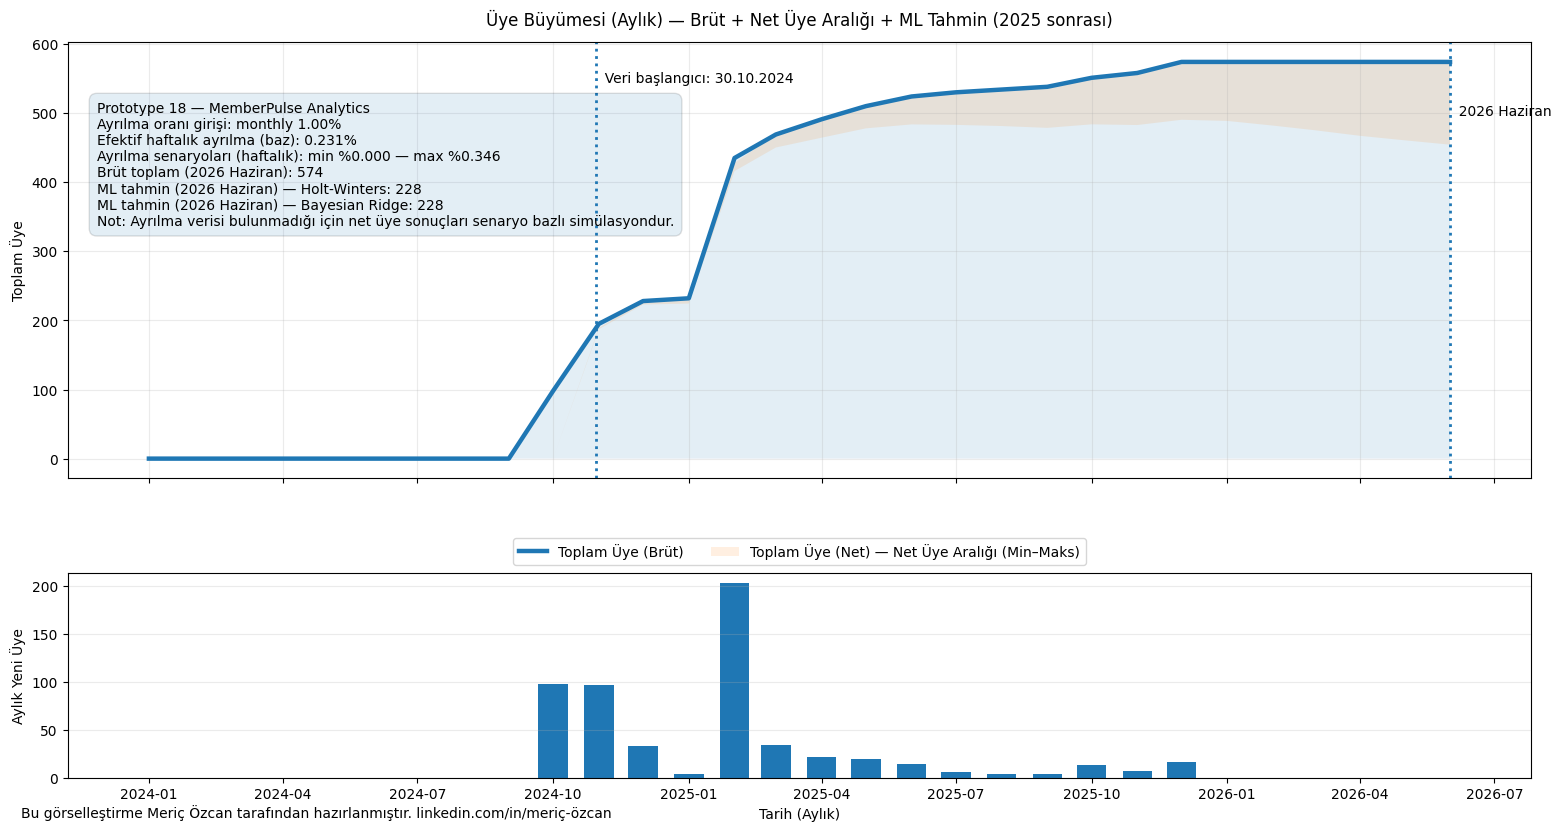

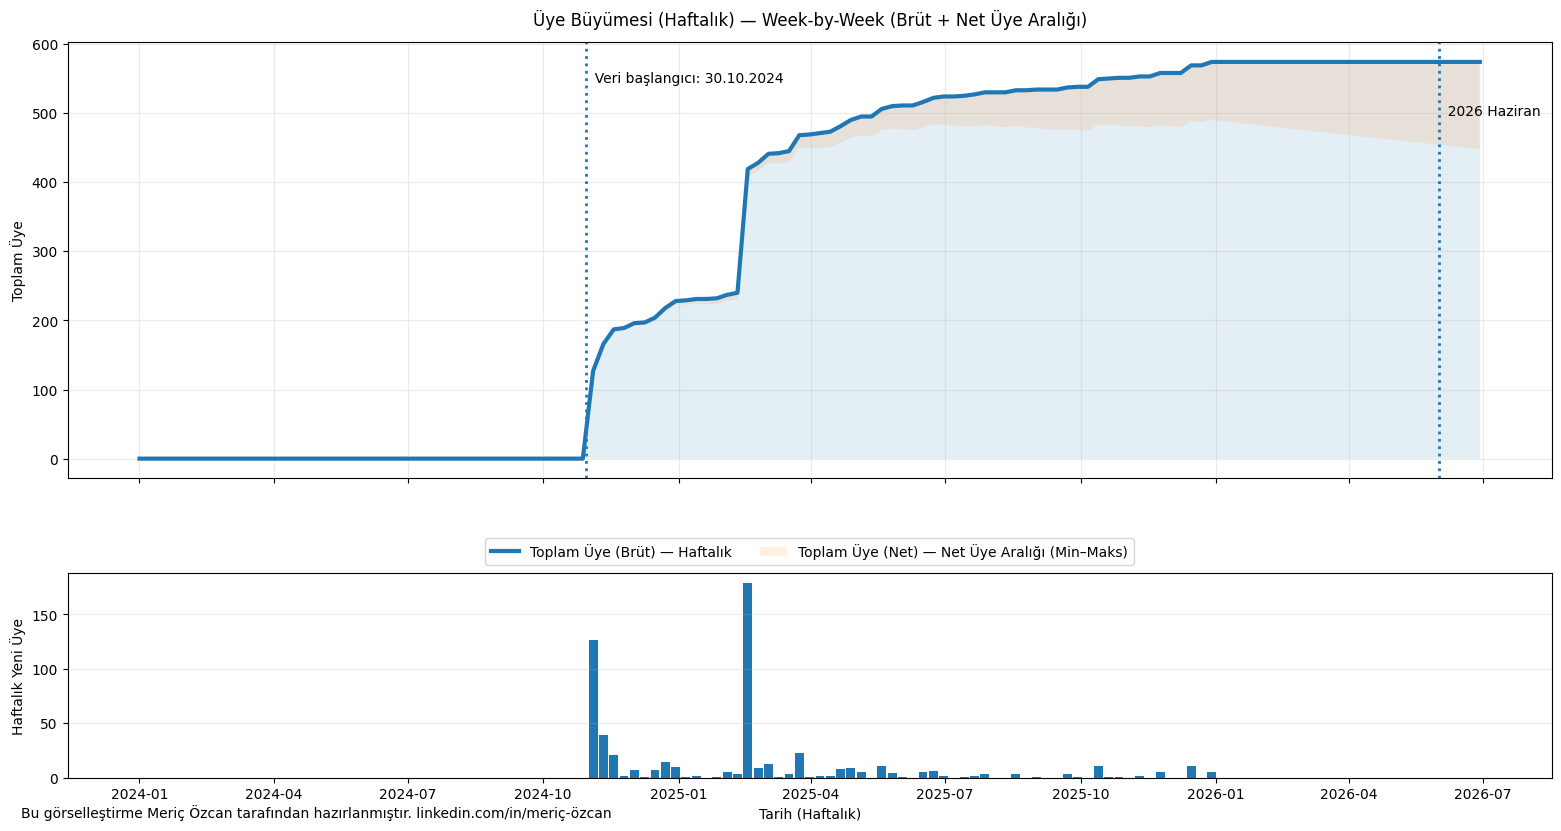

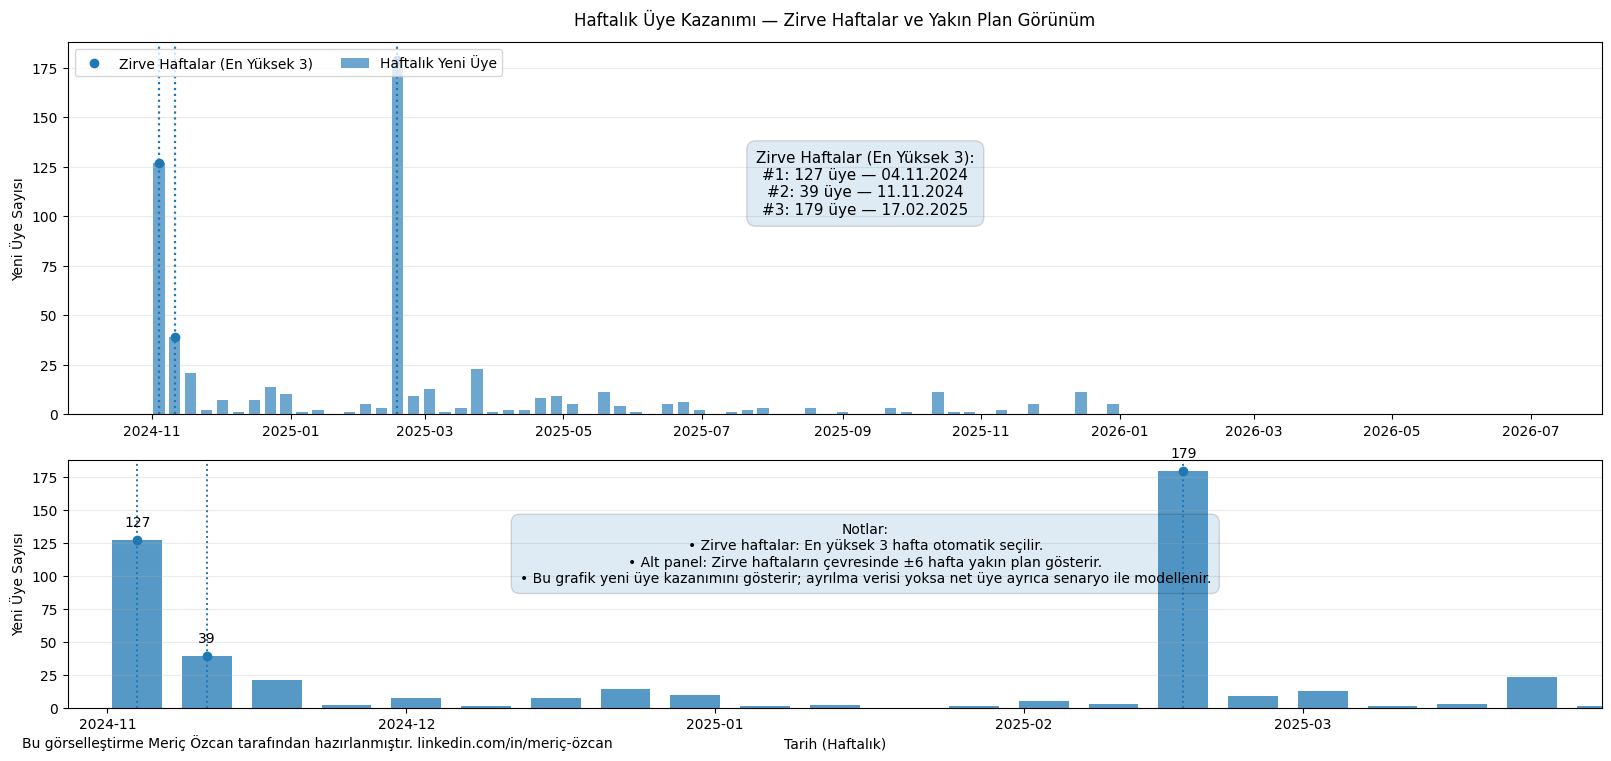

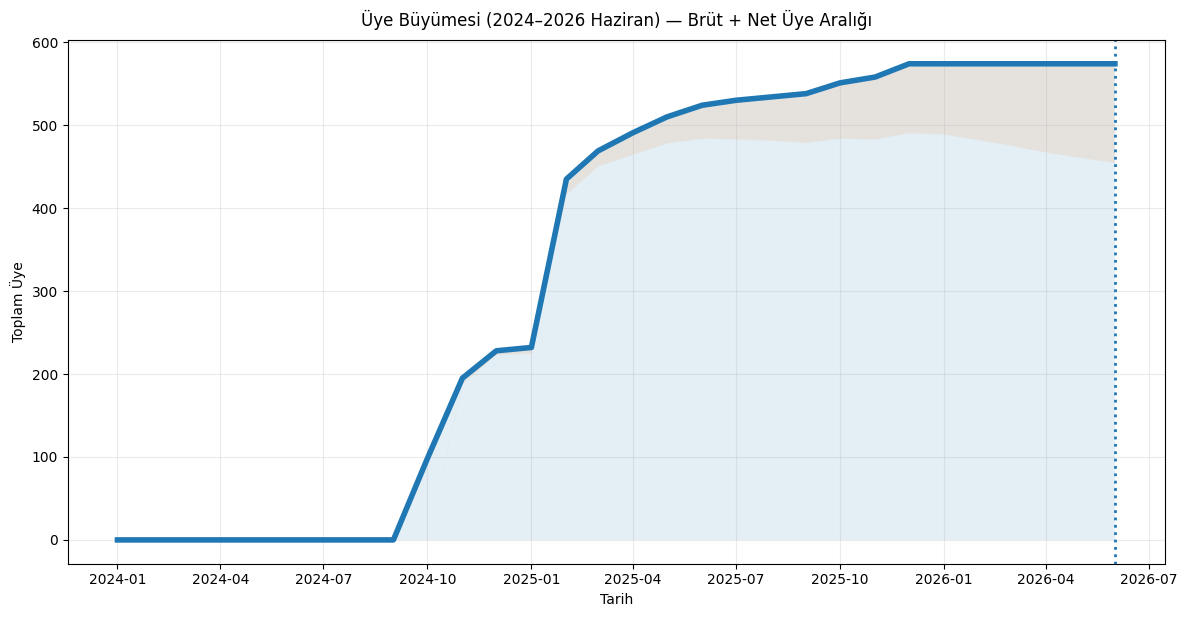

PPTX üretildi: /mnt/data/uye_buyume_sunum_v18.pptx

Üretildi:
 - /mnt/data/uye_buyume_main_aylik_ml_v18.png
 - /mnt/data/uye_buyume_weekly_v18.png
 - /mnt/data/uye_buyume_zirve_haftalar_v18.png
 - /mnt/data/uye_buyume_linkedin_1200x627_v18.png
 - /mnt/data/uye_buyume_sunum_v18.pptx

Not: ML tahminleri brüt yeni üye üzerinden hesaplanır; net üye aralığı, ayrılma oranı senaryolarına göre simüle edilir.
Ayrılma senaryoları (haftalık): ['%0.000', '%0.115', '%0.231', '%0.346']


In [25]:
# PROTOTYPE 18 — MemberPulse Analytics
# Üye Büyümesi (Aylık + Haftalık) + Ayrılma Oranı Senaryoları (Net Üye Aralığı) + ML Tahmin (2025 sonrası)
# + Zirve Haftalar (En Yüksek 3 Hafta) ve Yakın Plan (Zoom)
#
# Outputs:
# 1) /mnt/data/uye_buyume_main_aylik_ml_v18.png
# 2) /mnt/data/uye_buyume_weekly_v18.png
# 3) /mnt/data/uye_buyume_zirve_haftalar_v18.png
# 4) /mnt/data/uye_buyume_linkedin_1200x627_v18.png
# 5) /mnt/data/uye_buyume_sunum_v18.pptx   (opsiyonel)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import BayesianRidge

# ---- PPTX (optional) ----
PPTX_ENABLED = True
try:
    from pptx import Presentation
    from pptx.util import Inches
except Exception:
    PPTX_ENABLED = False

# -----------------------------
# 0) CONFIG
# -----------------------------
PROJECT_NAME = "Prototype 18 — MemberPulse Analytics"

PATH = "/content/DATA.089745"
os.makedirs("/mnt/data", exist_ok=True)

START = pd.Timestamp("2024-01-01")
END   = pd.Timestamp("2026-06-30")   # 2026 Haziran sonrası yok

# === Ayrılma Oranı (Üye Kaybı) Girişi ===
# period: "weekly" | "monthly" | "annual"
AYRILMA_GIRIS_PERIYODU = "monthly"
AYRILMA_GIRIS_ORANI    = 0.01          # örn: aylık %1

# Senaryo çarpanları (0 dahil): 0, yarısı, aynısı, 1.5 katı
SENARYO_CARPANLARI = [0.0, 0.5, 1.0, 1.5]

# ML eğitimi (2025 sonrası)
ML_TRAIN_START = "2025-01-01"

# Zirve haftalar görseli ayarları
ZIRVE_HAFTA_SAYISI = 3
ZOOM_WEEKS = 6  # zirvelerin etrafında +- kaç hafta

# Çıktılar
PNG_MAIN = "/mnt/data/uye_buyume_main_aylik_ml_v18.png"
PNG_WEEK = "/mnt/data/uye_buyume_weekly_v18.png"
PNG_PEAK = "/mnt/data/uye_buyume_zirve_haftalar_v18.png"
PNG_LI   = "/mnt/data/uye_buyume_linkedin_1200x627_v18.png"
PPTX_OUT = "/mnt/data/uye_buyume_sunum_v18.pptx"

SIGNATURE = "Bu görselleştirme Meriç Özcan tarafından hazırlanmıştır. linkedin.com/in/meriç-özcan"

# -----------------------------
# 1) AYRILMA ORANI DÖNÜŞÜMÜ (Bileşik/Compounded)
# -----------------------------
WEEKS_PER_YEAR = 365.25 / 7.0
WEEKS_PER_MONTH = WEEKS_PER_YEAR / 12.0

def haftaliga_cevir_ayrilma_orani(rate: float, period: str) -> float:
    if rate < 0 or rate >= 1:
        raise ValueError("AYRILMA_GIRIS_ORANI 0 ile 1 arasında olmalı (örn 0.06 = %6).")
    p = period.lower().strip()
    if p == "weekly":
        return rate
    if p == "monthly":
        return 1.0 - (1.0 - rate) ** (1.0 / WEEKS_PER_MONTH)
    if p == "annual":
        return 1.0 - (1.0 - rate) ** (1.0 / WEEKS_PER_YEAR)
    raise ValueError("AYRILMA_GIRIS_PERIYODU yalnızca 'weekly', 'monthly', 'annual' olabilir.")

base_haftalik_ayrilma = haftaliga_cevir_ayrilma_orani(AYRILMA_GIRIS_ORANI, AYRILMA_GIRIS_PERIYODU)

HAFTALIK_AYRILMA_SENARYOLARI = sorted(set([
    max(0.0, min(0.99, base_haftalik_ayrilma * m)) for m in SENARYO_CARPANLARI
]))

# -----------------------------
# 2) VERİ OKUMA (Her satır = 1 üye kaydı)
# -----------------------------
raw = pd.read_csv(PATH, header=None, names=["uye_id", "tarih_str"])
raw["tarih"] = pd.to_datetime(raw["tarih_str"], errors="coerce")
raw = raw.dropna(subset=["tarih"]).sort_values("tarih").reset_index(drop=True)

if raw.empty:
    raise ValueError("Tarih parse edilemedi. CSV formatını kontrol edin.")

data_start = raw["tarih"].min()

daily = raw.groupby(raw["tarih"].dt.floor("D")).size().rename("yeni_uye").to_frame()
daily["toplam_brut"] = daily["yeni_uye"].cumsum().astype(float)

idx_d = pd.date_range(START, END, freq="D")
ts_d = daily.reindex(idx_d)
ts_d["yeni_uye"] = ts_d["yeni_uye"].fillna(0).astype(float)
ts_d["toplam_brut"] = ts_d["toplam_brut"].ffill().fillna(0).astype(float)

# -----------------------------
# 3) HAFTALIK + AYLIK SERİ
# -----------------------------
weekly = pd.DataFrame(index=pd.date_range(START, END, freq="W-MON"))
weekly["yeni_uye"] = ts_d["yeni_uye"].resample("W-MON").sum().astype(float)
weekly["toplam_brut"] = ts_d["toplam_brut"].resample("W-MON").max().astype(float)

monthly = pd.DataFrame(index=pd.date_range(START, END, freq="MS"))
monthly["yeni_uye"] = ts_d["yeni_uye"].resample("MS").sum().astype(float)
monthly["toplam_brut"] = ts_d["toplam_brut"].resample("MS").max().astype(float)

# -----------------------------
# 4) NET ÜYE SİMÜLASYONU (Min–Maks Aralık)
# Net(t) = Net(t-1) + Yeni(t) − AyrılmaOranı × Net(t-1)
# -----------------------------
def net_uye_simulasyonu(weekly_df: pd.DataFrame, haftalik_ayrilma: float) -> np.ndarray:
    net = np.zeros(len(weekly_df), dtype=float)
    prev = 0.0
    for i, new in enumerate(weekly_df["yeni_uye"].values):
        prev = max(prev + new - haftalik_ayrilma * prev, 0.0)
        net[i] = prev
    return net

net_matrix = np.vstack([net_uye_simulasyonu(weekly, r) for r in HAFTALIK_AYRILMA_SENARYOLARI])
net_min_w = net_matrix.min(axis=0)
net_max_w = net_matrix.max(axis=0)

# Haftalık -> Aylık (aylık max)
net_min_m = pd.Series(net_min_w, index=weekly.index).resample("MS").max().reindex(monthly.index).ffill().fillna(0).values.astype(float)
net_max_m = pd.Series(net_max_w, index=weekly.index).resample("MS").max().reindex(monthly.index).ffill().fillna(0).values.astype(float)

# -----------------------------
# 5) ML TAHMİN (2025 sonrası) — Brüt haftalık yeni üye
# -----------------------------
train_w = weekly.loc[ML_TRAIN_START:, "yeni_uye"].copy()

hw_total_2026 = np.nan
br_total_2026 = np.nan
ml_note = ""

if len(train_w) >= 6:
    hw = ExponentialSmoothing(train_w, trend="add", seasonal=None).fit(optimized=True)

    X = np.arange(len(train_w)).reshape(-1, 1)
    y = train_w.values
    br = BayesianRidge().fit(X, y)

    future_index = weekly.loc[ML_TRAIN_START:END].index
    horizon = len(future_index)

    hw_pred = np.clip(np.array(hw.forecast(horizon), dtype=float), 0, None)
    br_pred = np.clip(np.array(br.predict(np.arange(len(train_w), len(train_w) + horizon).reshape(-1, 1)), dtype=float), 0, None)

    base_total_2024_end = float(monthly.loc["2024-12-01", "toplam_brut"]) if "2024-12-01" in monthly.index else 0.0
    hw_total_2026 = int(base_total_2024_end + hw_pred.sum())
    br_total_2026 = int(base_total_2024_end + br_pred.sum())

    ml_note = "ML tahminleri brüt yeni üye üzerinden hesaplanır; net üye aralığı, ayrılma oranı senaryolarına göre simüle edilir."
else:
    ml_note = "ML için yeterli haftalık veri yok (>=6 hafta önerilir)."

# -----------------------------
# 6) AYLIK GÖRSEL — Brüt + Net Üye Aralığı + KPI + Aylık Bar
# -----------------------------
x_m = monthly.index
y_m_brut = monthly["toplam_brut"].values.astype(float)

total_end_brut = int(ts_d.loc[END.floor("D"), "toplam_brut"]) if END.floor("D") in ts_d.index else int(y_m_brut[-1])

kpi_text = "\n".join([
    f"{PROJECT_NAME}",
    f"Ayrılma oranı girişi: {AYRILMA_GIRIS_PERIYODU} {AYRILMA_GIRIS_ORANI*100:.2f}%",
    f"Efektif haftalık ayrılma (baz): {base_haftalik_ayrilma*100:.3f}%",
    f"Ayrılma senaryoları (haftalık): min %{min(HAFTALIK_AYRILMA_SENARYOLARI)*100:.3f} — max %{max(HAFTALIK_AYRILMA_SENARYOLARI)*100:.3f}",
    f"Brüt toplam (2026 Haziran): {str(total_end_brut).replace(',', '.')}",
    f"ML tahmin (2026 Haziran) — Holt-Winters: {str(hw_total_2026).replace(',', '.')}",
    f"ML tahmin (2026 Haziran) — Bayesian Ridge: {str(br_total_2026).replace(',', '.')}",
    "Not: Ayrılma verisi bulunmadığı için net üye sonuçları senaryo bazlı simülasyondur."
])

fig = plt.figure(figsize=(15.5, 8.2), constrained_layout=True)
gs = fig.add_gridspec(2, 1, height_ratios=[3.2, 1.5])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)

ax1.plot(x_m, y_m_brut, linewidth=3.2, label="Toplam Üye (Brüt)")
ax1.fill_between(x_m, y_m_brut, alpha=0.12)

ax1.fill_between(x_m, net_min_m, net_max_m, alpha=0.12, label="Toplam Üye (Net) — Net Üye Aralığı (Min–Maks)")

ax1.axvline(data_start, linestyle=":", linewidth=2)
ax1.text(data_start, ax1.get_ylim()[1]*0.93, f"  Veri başlangıcı: {data_start:%d.%m.%Y}", va="top")

cut = pd.Timestamp("2026-06-01")
ax1.axvline(cut, linestyle=":", linewidth=2)
ax1.text(cut, ax1.get_ylim()[1]*0.85, "  2026 Haziran", va="top")

ax1.text(
    0.02, 0.58, kpi_text,
    transform=ax1.transAxes,
    fontsize=10.0,
    bbox=dict(boxstyle="round,pad=0.55", alpha=0.12)
)

ax1.set_title("Üye Büyümesi (Aylık) — Brüt + Net Üye Aralığı + ML Tahmin (2025 sonrası)", pad=12)
ax1.set_ylabel("Toplam Üye")
ax1.grid(True, alpha=0.25)

ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=True)

ax2.bar(x_m, monthly["yeni_uye"].values.astype(float), width=20)
ax2.set_ylabel("Aylık Yeni Üye")
ax2.set_xlabel("Tarih (Aylık)")
ax2.grid(True, axis="y", alpha=0.25)
plt.setp(ax1.get_xticklabels(), visible=False)

fig.text(0.01, 0.01, SIGNATURE, fontsize=10)
fig.savefig(PNG_MAIN, dpi=300, bbox_inches="tight")
plt.show()

# -----------------------------
# 7) HAFTALIK GÖRSEL — Brüt + Net Üye Aralığı + Haftalık Bar
# -----------------------------
x_w = weekly.index
y_w_brut = weekly["toplam_brut"].values.astype(float)

fig2 = plt.figure(figsize=(15.5, 8.2), constrained_layout=True)
gs2 = fig2.add_gridspec(2, 1, height_ratios=[3.2, 1.5])

bx1 = fig2.add_subplot(gs2[0])
bx2 = fig2.add_subplot(gs2[1], sharex=bx1)

bx1.plot(x_w, y_w_brut, linewidth=3.0, label="Toplam Üye (Brüt) — Haftalık")
bx1.fill_between(x_w, y_w_brut, alpha=0.12)

bx1.fill_between(x_w, net_min_w, net_max_w, alpha=0.12, label="Toplam Üye (Net) — Net Üye Aralığı (Min–Maks)")

bx1.axvline(data_start, linestyle=":", linewidth=2)
bx1.text(data_start, bx1.get_ylim()[1]*0.93, f"  Veri başlangıcı: {data_start:%d.%m.%Y}", va="top")

bx1.axvline(pd.Timestamp("2026-06-01"), linestyle=":", linewidth=2)
bx1.text(pd.Timestamp("2026-06-01"), bx1.get_ylim()[1]*0.85, "  2026 Haziran", va="top")

bx1.set_title("Üye Büyümesi (Haftalık) — Week-by-Week (Brüt + Net Üye Aralığı)", pad=12)
bx1.set_ylabel("Toplam Üye")
bx1.grid(True, alpha=0.25)

bx1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=True)

bx2.bar(x_w, weekly["yeni_uye"].values.astype(float), width=6)
bx2.set_ylabel("Haftalık Yeni Üye")
bx2.set_xlabel("Tarih (Haftalık)")
bx2.grid(True, axis="y", alpha=0.25)
plt.setp(bx1.get_xticklabels(), visible=False)

fig2.text(0.01, 0.01, SIGNATURE, fontsize=10)
fig2.savefig(PNG_WEEK, dpi=300, bbox_inches="tight")
plt.show()

# -----------------------------
# 8) ZİRVE HAFTALAR + ZOOM GÖRSELİ (En yüksek 3 hafta)
# -----------------------------
w = weekly["yeni_uye"].copy()

# Boş dönemi kırp: veri başlangıcından biraz önce başlat
plot_start = max(w.index.min(), data_start.floor("D") - pd.Timedelta(days=7))
w_plot = w.loc[plot_start:END].copy()

peaks = w_plot.sort_values(ascending=False).head(ZIRVE_HAFTA_SAYISI).sort_index()

zoom_min = peaks.index.min() - pd.Timedelta(weeks=ZOOM_WEEKS)
zoom_max = peaks.index.max() + pd.Timedelta(weeks=ZOOM_WEEKS)
zoom_min = max(zoom_min, w_plot.index.min())
zoom_max = min(zoom_max, w_plot.index.max())

figp = plt.figure(figsize=(16, 7.5), constrained_layout=True)
gsp = figp.add_gridspec(2, 1, height_ratios=[2.1, 1.4])

ax_full = figp.add_subplot(gsp[0])
ax_zoom = figp.add_subplot(gsp[1], sharey=ax_full)

# Full
ax_full.bar(w_plot.index, w_plot.values, width=5, alpha=0.65, label="Haftalık Yeni Üye")
ax_full.plot(
    peaks.index, peaks.values, marker="o", linewidth=0,
    label=f"Zirve Haftalar (En Yüksek {ZIRVE_HAFTA_SAYISI})"
)

# Dikey çizgiler (anotasyon yerine sabit bilgi kutusu kullanacağız)
peak_lines = []
for i, (dt, val) in enumerate(peaks.items(), start=1):
    ax_full.axvline(dt, linestyle=":", linewidth=1.6)
    peak_lines.append(f"#{i}: {int(val)} üye — {dt:%d.%m.%Y}")

# ✅ ÜST PANEL: Bilgiyi grafiğin ortasına topla
ax_full.text(
    0.52, 0.62,
    "Zirve Haftalar (En Yüksek 3):\n" + "\n".join(peak_lines),
    transform=ax_full.transAxes,
    ha="center", va="center",
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.6", alpha=0.14)
)

ax_full.set_title("Haftalık Üye Kazanımı — Zirve Haftalar ve Yakın Plan Görünüm", pad=12)
ax_full.set_ylabel("Yeni Üye Sayısı")
ax_full.grid(True, axis="y", alpha=0.25)
ax_full.legend(loc="upper left", ncol=2, frameon=True)

# Zoom
w_zoom = w_plot.loc[zoom_min:zoom_max]
ax_zoom.bar(w_zoom.index, w_zoom.values, width=5, alpha=0.75, label="Yakın Plan (Zoom)")

peaks_zoom = peaks.loc[(peaks.index >= zoom_min) & (peaks.index <= zoom_max)]
ax_zoom.plot(peaks_zoom.index, peaks_zoom.values, marker="o", linewidth=0)

for dt, val in peaks_zoom.items():
    ax_zoom.axvline(dt, linestyle=":", linewidth=1.4)
    ax_zoom.annotate(
        f"{int(val)}",
        xy=(dt, val),
        xytext=(0, 8),
        textcoords="offset points",
        ha="center", va="bottom",
        fontsize=10
    )

ax_zoom.set_xlim(zoom_min, zoom_max)
ax_zoom.set_xlabel("Tarih (Haftalık)")
ax_zoom.set_ylabel("Yeni Üye Sayısı")
ax_zoom.grid(True, axis="y", alpha=0.25)

info = (
    "Notlar:\n"
    f"• Zirve haftalar: En yüksek {ZIRVE_HAFTA_SAYISI} hafta otomatik seçilir.\n"
    f"• Alt panel: Zirve haftaların çevresinde ±{ZOOM_WEEKS} hafta yakın plan gösterir.\n"
    "• Bu grafik yeni üye kazanımını gösterir; ayrılma verisi yoksa net üye ayrıca senaryo ile modellenir."
)

# ✅ ALT PANEL: Notlar kutusunu grafiğin ortasına al
ax_zoom.text(
    0.52, 0.62,
    info,
    transform=ax_zoom.transAxes,
    ha="center", va="center",
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.6", alpha=0.14)
)

figp.text(0.01, 0.01, SIGNATURE, fontsize=10)
figp.savefig(PNG_PEAK, dpi=300, bbox_inches="tight")
plt.show()

# -----------------------------
# 9) LINKEDIN 1200×627
# -----------------------------
plt.figure(figsize=(12, 6.27))
plt.plot(x_m, y_m_brut, linewidth=4)
plt.fill_between(x_m, y_m_brut, alpha=0.12)
plt.fill_between(x_m, net_min_m, net_max_m, alpha=0.10)
plt.axvline(pd.Timestamp("2026-06-01"), linestyle=":", linewidth=2)
plt.title("Üye Büyümesi (2024–2026 Haziran) — Brüt + Net Üye Aralığı", pad=10)
plt.xlabel("Tarih")
plt.ylabel("Toplam Üye")
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.savefig(PNG_LI, dpi=300, bbox_inches="tight")
plt.show()

# -----------------------------
# 10) PPTX (opsiyonel)
# -----------------------------
if PPTX_ENABLED:
    prs = Presentation()

    s1 = prs.slides.add_slide(prs.slide_layouts[5])
    s1.shapes.add_picture(PNG_MAIN, Inches(0.4), Inches(0.4), width=Inches(9.2))
    tb1 = s1.shapes.add_textbox(Inches(0.4), Inches(6.3), Inches(9.2), Inches(0.8))
    tb1.text_frame.text = f"{PROJECT_NAME}\nAylık — Brüt + Net Üye Aralığı + ML Tahmin\nHazırlayan: Meriç Özcan | linkedin.com/in/meriç-özcan"

    s2 = prs.slides.add_slide(prs.slide_layouts[5])
    s2.shapes.add_picture(PNG_WEEK, Inches(0.4), Inches(0.4), width=Inches(9.2))
    tb2 = s2.shapes.add_textbox(Inches(0.4), Inches(6.3), Inches(9.2), Inches(0.8))
    tb2.text_frame.text = f"{PROJECT_NAME}\nHaftalık — Week-by-Week (Brüt + Net Üye Aralığı)\nHazırlayan: Meriç Özcan | linkedin.com/in/meriç-özcan"

    s3 = prs.slides.add_slide(prs.slide_layouts[5])
    s3.shapes.add_picture(PNG_PEAK, Inches(0.4), Inches(0.4), width=Inches(9.2))
    tb3 = s3.shapes.add_textbox(Inches(0.4), Inches(6.3), Inches(9.2), Inches(0.8))
    tb3.text_frame.text = f"{PROJECT_NAME}\nZirve Haftalar — Yakın Plan Görünüm\nHazırlayan: Meriç Özcan | linkedin.com/in/meriç-özcan"

    s4 = prs.slides.add_slide(prs.slide_layouts[5])
    s4.shapes.add_picture(PNG_LI, Inches(0.6), Inches(0.8), width=Inches(8.8))
    tb4 = s4.shapes.add_textbox(Inches(0.6), Inches(6.3), Inches(8.8), Inches(0.8))
    tb4.text_frame.text = f"{PROJECT_NAME}\nLinkedIn Görseli (1200×627)\nHazırlayan: Meriç Özcan | linkedin.com/in/meriç-özcan"

    prs.save(PPTX_OUT)
    print("PPTX üretildi:", PPTX_OUT)
else:
    print("PPTX atlandı: python-pptx yüklü değil. (Colab: !pip install python-pptx)")

print("\nÜretildi:")
print(" -", PNG_MAIN)
print(" -", PNG_WEEK)
print(" -", PNG_PEAK)
print(" -", PNG_LI)
if PPTX_ENABLED:
    print(" -", PPTX_OUT)

print("\nNot:", ml_note)
print("Ayrılma senaryoları (haftalık):", [f"%{r*100:.3f}" for r in HAFTALIK_AYRILMA_SENARYOLARI])

In [ ]:
# MemberPulse Analytics
## Membership Growth, Attrition-Adjusted Scenarios & Forecasting (2024–2026)

This notebook presents a **management-ready analytics pipeline** designed to analyze and communicate how an organization’s membership evolves over time, using both **monthly** and **week-by-week** perspectives.

---

### What this notebook does
- Processes raw membership records where each row represents **one member and their joining date**
- Constructs **daily, weekly, and monthly** time series including:
  - Newly joined members per period
  - Total member count over time (gross growth)
- Produces clear, executive-level visualizations:
  - **Monthly view:** total members over time with monthly new-member bars
  - **Weekly view:** week-by-week growth with short-term dynamics highlighted
  - **Peak weeks view:** identification of the top growth weeks

---

### Member Attrition (Ayrılmalar) — Scenario-Based Net Growth
The available dataset includes **only member join records** and does not contain real data on members leaving the organization.

To transparently address this limitation, the analysis applies a **scenario-based member loss (attrition) simulation**:

- Management can specify an estimated attrition rate as **annual, monthly, or weekly**
- The pipeline converts this estimate into an **effective weekly attrition rate** using a compounded transformation
- Net membership is simulated as:

  **Net Members(t) = Net Members(t−1) + New Members(t) − Estimated Attrition × Net Members(t−1)**

Instead of a single number, results are presented as a **net growth band (minimum–maximum)** to reflect uncertainty and avoid overconfidence.

---

### Growth Forecasting (Post-2025) — Machine Learning Comparison
For the period after 2025, the notebook estimates **future member acquisition** using two complementary methods:

- **Holt-Winters (Exponential Smoothing):** captures medium-term growth trends
- **Bayesian Ridge Regression:** provides a probabilistic baseline using time progression

Forecast results are shown as **KPI-style summaries** and are intentionally **not extrapolated beyond the reporting window**, ensuring interpretability.

---

### Outputs
The notebook automatically generates:
- A main monthly growth figure (gross growth + attrition-adjusted net band + KPIs)
- A detailed weekly growth figure
- A dedicated visualization highlighting **peak growth weeks**
- A LinkedIn-ready visual (1200×627)
- A PowerPoint (PPTX) presentation with key charts for management review

---

### Notes & Assumptions
- Net member growth is **scenario-based**, as real member exit data is not available
- Forecasts estimate **new member acquisition**, not guaranteed net membership
- All assumptions are explicitly stated to support transparent decision-making

---

**Prepared by:** Meriç Özcan
**LinkedIn:** https://www.linkedin.com/in/meriç-özcan